# Multi Salmo microbetag networks analysis

## Functions

Load dependencies

In [1]:
import os
from dataclasses import dataclass

import matplotlib.pyplot as plt
import matplotlib.lines as mlines


try:
    from ndex2.cx2 import RawCX2NetworkFactory
except ImportError:
    %pip install ndex2
    from ndex2.cx2 import RawCX2NetworkFactory

try:
    import venn
except ImportError:
    %pip install venn
    import venn
from venn import venn

Functions for the needs of the stats.

In [2]:
def load_cx2(filepath):
    """
    Load a .cx2 network with ndex2
    """
    factory = RawCX2NetworkFactory()
    net = factory.get_cx2network(filepath)
    return net

In [3]:
def parse_microbetag_edges(cx2, env_set, metabolites_set):
    """
    Gets a ndex2 object as retruned from loading a .cx2 microbetag annotated network 
    and returns

    Arguments: 
    - cx2 (ndex2.cx2.CX2Network): 
    - env_set (Set): 
    - metabolites_set (Set):
    
    Returns:
    - edge_id_2_number_of_complements (Dict)
    - edge_types (Dict): 
    - taxa_pairs_with_positive_weight (List): 
    - edge_id_2_cross_feeding_compounds (Dict):
    """

    edge_id_sign = {}
    edge_id_2_number_of_complements = {}
    edge_id_2_cross_feeding_compounds = {}
    edge_types = {
        "taxon_to_taxon": {"edges": [], "counts": 0},  # done
        "taxon_to_metabo": {"edges": [], "counts": 0},
        "taxon_to_env": {"edges": [], "counts": 0}, 
        "metabo_to_metabo": {"edges": [], "counts": 0}, # done
        "env_to_env": {"edges": [], "counts": 0},       # done
        "metabo_to_env": {"edges": [], "counts": 0}
    }

    source_target_edge_ids = {}
    taxa_pairs_with_positive_weight = []

    for _, edge in cx2.get_edges().items():
        
        edge_id = edge["id"]

        if "completes/competes with" == edge["v"]["interaction type"]:
            for k in edge["v"]:
                # NOTE For PATHWAY COMPLEMENTS
                # if "compl::" in k:
                #     edge_id_2_number_of_complements[edge_id] = len(edge["v"][k])
                uniq_cross_feeding_compounds = set()
                if k.startswith("seedCompl::"):
                    edge_id_2_number_of_complements[edge_id] = len(edge["v"][k])
                    for compl in edge["v"][k]:
                        for i in compl.split("^")[2].split(";"): uniq_cross_feeding_compounds.add(i)
                    edge_id_2_cross_feeding_compounds[edge_id] = uniq_cross_feeding_compounds
        else:
            if 'microbetag::weight' in edge["v"]:
                if edge["v"]["microbetag::weight"] > 0:
                    edge_id_sign[edge_id] = 1
                    taxa_pairs_with_positive_weight.append((edge["s"], edge["t"]))
                else:
                    edge_id_sign[edge_id] = -1

        source_target_edge_ids[(edge["s"], edge["t"])] = edge_id

        source, target = edge["s"], edge["t"]
        
        node_source = cx2.get_nodes()[source]
        source_name = node_source["v"]["name"]
        
        node_target = cx2.get_nodes()[target]
        target_name = node_target["v"]["name"]
        
        if source_name not in env_set | metabolites_set and target_name not in env_set | metabolites_set:
            edge_types["taxon_to_taxon"]["counts"] += 1
            edge_types["taxon_to_taxon"]["edges"].append(edge_id)

        elif source_name in env_set and target_name in env_set:
            edge_types["env_to_env"]["counts"] += 1
            edge_types["env_to_env"]["edges"].append(edge_id)

        elif source_name in metabolites_set and target_name in metabolites_set:
            edge_types["metabo_to_metabo"]["counts"] += 1
            edge_types["metabo_to_metabo"]["edges"].append(edge_id)

        elif {source_name, target_name} <= env_set | metabolites_set and source_name in env_set ^ metabolites_set:
            edge_types["metabo_to_env"]["counts"] += 1
            edge_types["metabo_to_env"]["edges"].append(edge_id)

        elif {source_name, target_name} & env_set and not {source_name, target_name} & metabolites_set:
            edge_types["taxon_to_env"]["counts"] += 1
            edge_types["taxon_to_env"]["edges"].append(edge_id)

        elif {source_name, target_name} & metabolites_set and not {source_name, target_name} & env_set:
            edge_types["taxon_to_metabo"]["counts"] += 1
            edge_types["taxon_to_metabo"]["edges"].append(edge_id)

        else:
            print("PROBLEM:", source_name, target_name)

    return edge_id_2_number_of_complements, edge_types, taxa_pairs_with_positive_weight, edge_id_2_cross_feeding_compounds


In [4]:
def get_compls_and_compounds_in_positive_associated_taxa(cx2, positive_pairs, edge_id_compl_number, compounds):

    number_of_complements_in_positive_associated_taxa = 0
    unique_compounds = set()
    for _, edge in cx2.get_edges().items():

        s_t = (edge["s"], edge["t"])
        t_s = (edge["t"], edge["s"])
        edge_id = edge["id"]

        if s_t in positive_pairs or t_s in positive_pairs:
            if edge["v"]["interaction type"] == "completes/competes with":
                for k in edge["v"]:
                    if k.startswith("seedCompl::"):
                        number_of_complements_in_positive_associated_taxa += edge_id_compl_number[edge_id]
                        for i in compounds[edge_id]:
                            unique_compounds.add(i)

    return number_of_complements_in_positive_associated_taxa, unique_compounds

A `dataclass` for the parsed microbetag annotated network once loaded with `ndex2`; instances of this class will store outputs of the `parse_microbetag_egdes()`.

In [5]:
@dataclass
class MggParser():

    import ndex2

    num_total_compls: dict
    edge_types: dict
    pos_pairs_node_ids: list  # of tuples
    edge_id_to_unique_compounds: dict
    cx2: ndex2.cx2.CX2Network

    def __init__(self, cx2, env_set, metabolites_set) -> None:
        
        (
            self.num_total_compls,
            self.edge_types,
            self.pos_pairs_node_ids, 
            self.edge_id_to_unique_compounds 
         ) = parse_microbetag_edges(cx2, env_set, metabolites_set)
        self.cx2 = cx2

## Discussing the nets

***Salmonella*** is *positively* associated with **lactic acid**; in agreement with in vitro data. 

It’s also *negatively* associated with ***Lactobacillus johnsonii***, with a stronger negative than positive seed score. That means that *Lactobacillus johnsonii* is another probiotic candidate species.

*Salmonella* is also *negatively* associated with **time**, which is not unexpected.

***Ligilactobacillus salivarius*** (PoultryStar member) is *positively* associated to **synbiont-water**, in addition to **TG4** (no PoultryStar), so it does show up in some chickens supposed to have received it. 
Maybe that means that it is present in some hosts prior to treatment. 

**TG1** is linked to *Tyzzerella sp.* both in the global network and day 7 network.

Early days are more strongly shaped by treatment groups than later days.

Also, there are more taxon-metabolite associations in later days, with a peak in day 21.

There is a jump in node and edge number from 7 to 21 days, though the overall (Pearson) correlation of day to edge or node number is not significant.
Thus, the network gets more complex with changing feeding habits.


It seems that from day 28 to 35, even the number of edges is decreasing, the potential cross feedings are increased.

## Stats

### Prep

Keep track of the non-sequence nodes.

In [6]:
env_var = ["treatment_TG1", "treatment_TG2", "treatment_TG3", "treatment_TG4", "treatment_TG5", 
           "day", "salmonella", "synbiotic_water", "synbiotic_feed"
]
metabolites = [
"L-Tyrosine", "L-Phenylalanine", "L-Tryptophan", "L-Aspartic Acid", "L-Arginine", "L-Leucine", "L-Glutamic acid", "L-Glutamine", 
"L-Histidine", "L-Lysine", "L-Methionine", "L-Proline", "L-Threonine", "Thiamine", "Adenine", 'Guanosine', "L-Valine" , "L-Alanine", 
"L-Asparagine", "L-Isoleucine", "L-Serine", "Lactic acid", "Sulfoacetic acid"
]
env_set = set(env_var)
metabolites_set = set(metabolites)

In [7]:
cx_dir = "/home/luna.kuleuven.be/u0156635/Documents/projects/3D-omics-general/results"

### Per day networks

#### Prep

Calculate statistics on the microbetag-annotated networks per day.

Load the `.cx2` files 

In [8]:
cx_07_filepath = os.path.join(cx_dir, "microbetag_net_day_7.cx2")  ; cx_07 = load_cx2(cx_07_filepath)
cx_14_filepath = os.path.join(cx_dir, "microbetag_net_day_14.cx2") ; cx_14 = load_cx2(cx_14_filepath)
cx_21_filepath = os.path.join(cx_dir, "microbetag_net_day_21.cx2") ; cx_21 = load_cx2(cx_21_filepath)
cx_28_filepath = os.path.join(cx_dir, "microbetag_net_day_28.cx2") ; cx_28 = load_cx2(cx_28_filepath)
cx_35_filepath = os.path.join(cx_dir, "microbetag_net_day_35.cx2") ; cx_35 = load_cx2(cx_35_filepath)

Example of how an edge looks like on the `.cx2` format.
```json

// Edge example
    {'id': 245,
    's': 83,
    't': 2,
    'v': {'interaction type': 'cooccurrence',
    'microbetag::weight': 0.9523214101791382,
    'shared name': 'L-Leucine (cooccurss with) L-Isoleucine'}}

```

In [9]:
days = [7, 14, 21, 28, 35]

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [10]:
days_parsed_nets = {
    "day07" : MggParser(cx_07, env_set, metabolites_set),
    "day14" : MggParser(cx_14, env_set, metabolites_set),
    "day21" : MggParser(cx_21, env_set, metabolites_set),
    "day28" : MggParser(cx_28, env_set, metabolites_set),
    "day35" : MggParser(cx_35, env_set, metabolites_set)
}

In [11]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in days_parsed_nets.items()
]

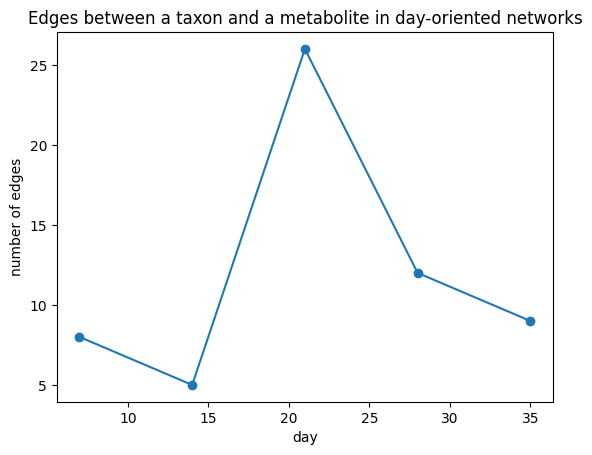

In [12]:
# What to plot
plt.plot(days, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in day-oriented networks")
# Show time
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [13]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in days_parsed_nets.items()
]

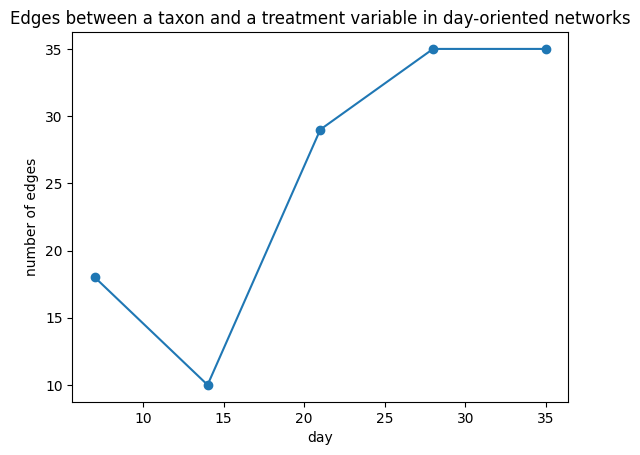

In [14]:
# What to plot
plt.plot(days, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a treatment variable in day-oriented networks")
# Show time
plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [15]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in days_parsed_nets.items()
]

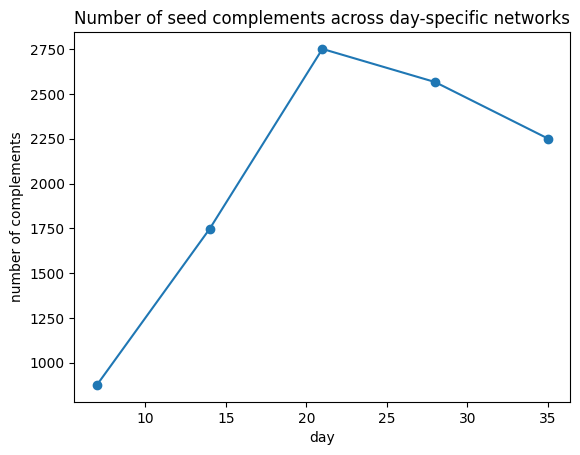

In [16]:
# What to plot
plt.plot(days, overall_number_of_seed_compl, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements across day-specific networks")
# Show time
plt.show()


#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [17]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in days_parsed_nets.items()
]

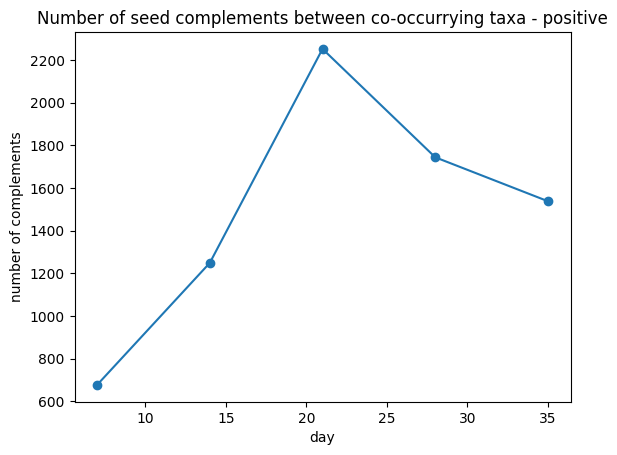

In [18]:
# What to plot
plt.plot(days, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")
# Show time
plt.show()


In [19]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(days_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(days_parsed_nets.values())
]

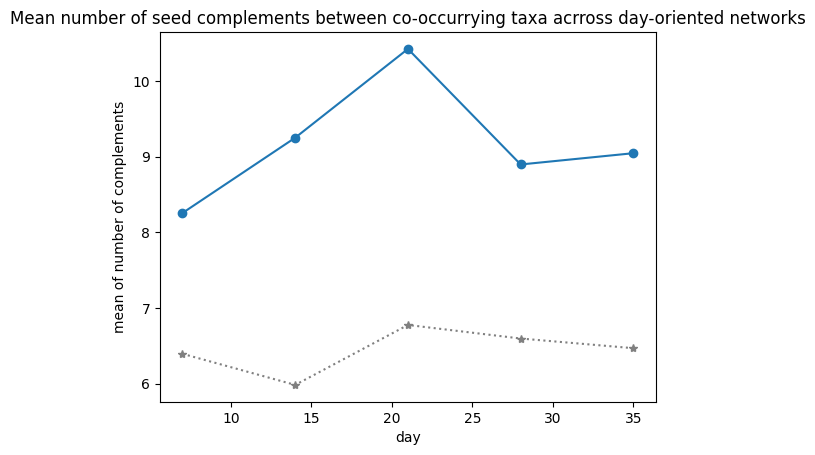

In [20]:
# What to plot
plt.plot(days, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(days, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")
# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross day-oriented networks")
# Show time
plt.show()

#### Unique compounds involved in potential cross-feedings

In [21]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in days_parsed_nets.items()
]

In [22]:
lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

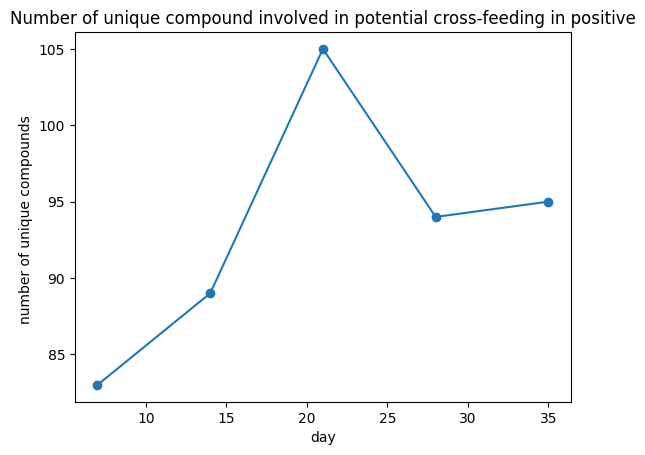

In [23]:
plt.plot(days, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [24]:
day_set = { "day_" + str(i): j for i,j in zip(days, unique_compounds_in_cf_of_positive_associated_taxa)}

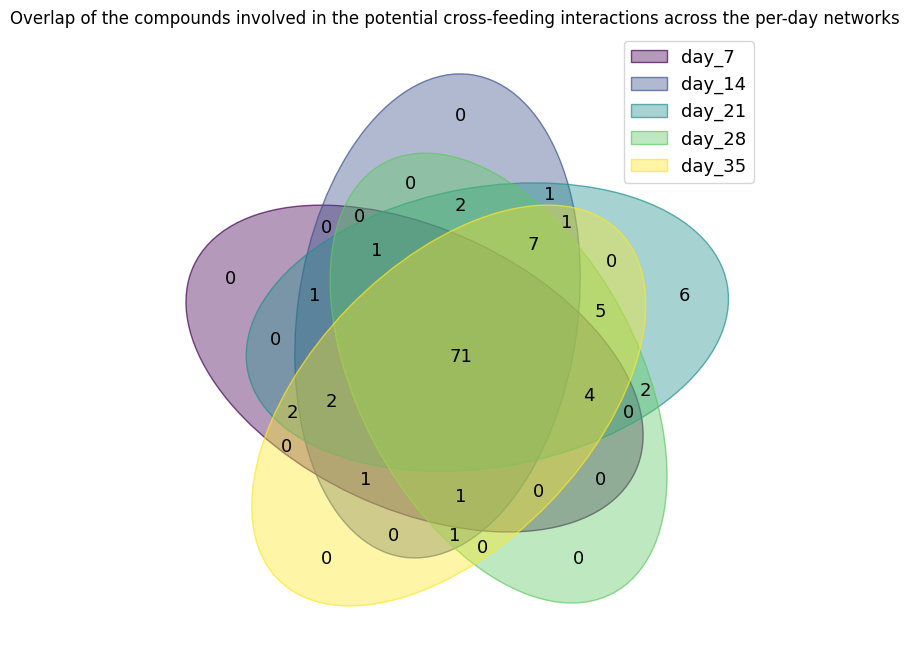

In [25]:
venn(day_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-day networks")

# Show the plot
plt.show()

### Per treatment

#### Prep

In [26]:
cx_tg1_filepath = os.path.join(cx_dir, "microbetag_net_TG1.cx2") ; cx_tg_1 = load_cx2(cx_tg1_filepath)
cx_tg2_filepath = os.path.join(cx_dir, "microbetag_net_TG2.cx2") ; cx_tg_2 = load_cx2(cx_tg2_filepath)
cx_tg3_filepath = os.path.join(cx_dir, "microbetag_net_TG3.cx2") ; cx_tg_3 = load_cx2(cx_tg3_filepath)
cx_tg4_filepath = os.path.join(cx_dir, "microbetag_net_TG4.cx2") ; cx_tg_4 = load_cx2(cx_tg4_filepath)
cx_tg5_filepath = os.path.join(cx_dir, "microbetag_net_TG5.cx2") ; cx_tg_5 = load_cx2(cx_tg5_filepath)

In [27]:
tg_microbetag_nets = [cx_tg_1, cx_tg_2, cx_tg_3, cx_tg_4, cx_tg_5]
treatments = ["TG1", "TG2", "TG3", "TG4", "TG5"]
treatments_descr = [
    "TG1:Salmonella, synbiont both water and feed",
    "TG2:Salmonella, synbiont in water",
    "TG3:Salmonella, synbiont in feed",
    "TG4:Salmonella, no symbiont",
    "TG5:No Salmonella, no symbiont"
]

In [28]:
parsed_tg_edges = []
for tg_mgg_net in tg_microbetag_nets:
    num_compl, types, pos_pairs, compounds = parse_microbetag_edges(tg_mgg_net, env_set=env_set, metabolites_set=metabolites_set)
    parsed_tg_edges.append([num_compl, types, pos_pairs, compounds])

In [29]:
treatment_parsed_nets = {
    "TG1" : MggParser(cx_tg_1, env_set, metabolites_set),
    "TG2" : MggParser(cx_tg_2, env_set, metabolites_set),
    "TG3" : MggParser(cx_tg_3, env_set, metabolites_set),
    "TG4" : MggParser(cx_tg_4, env_set, metabolites_set),
    "TG5" : MggParser(cx_tg_5, env_set, metabolites_set)
}

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [30]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in treatment_parsed_nets.items()
]

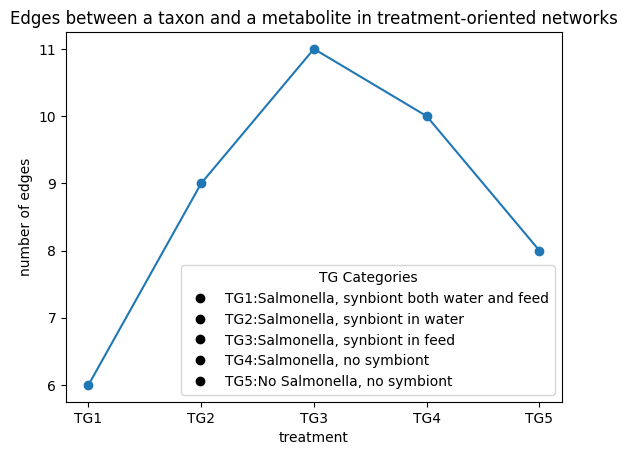

In [31]:
plt.plot(treatments, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in treatment-oriented networks")
# Create proxy artists for legend
legend_handles = [mlines.Line2D([], [], color='black', marker='o', linestyle='None', label=t) for t in treatments_descr]
# Add legend box
plt.legend(handles=legend_handles, title="TG Categories", loc="lower right", frameon=True)
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [32]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in treatment_parsed_nets.items()
]

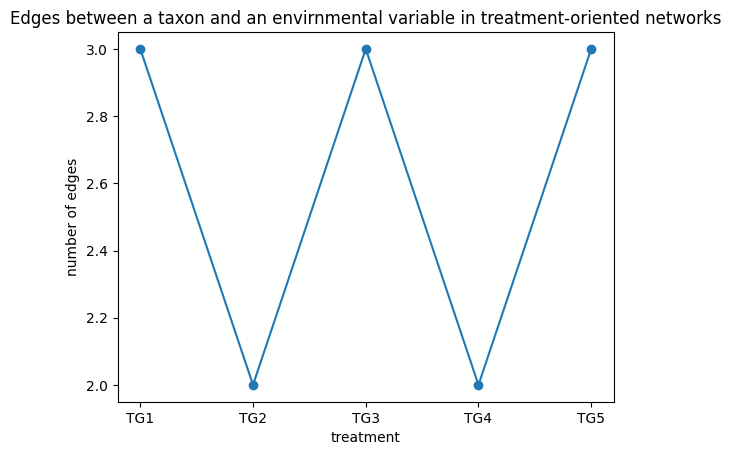

In [33]:
plt.plot(treatments, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and an envirnmental variable in treatment-oriented networks")

plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [34]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in treatment_parsed_nets.items()
]

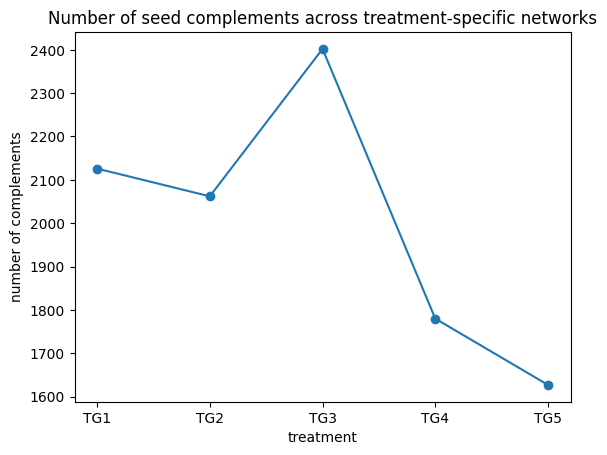

In [35]:
plt.plot(treatments, overall_number_of_seed_compl, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements across treatment-specific networks")

# Show the plot
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [36]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in treatment_parsed_nets.items()
]

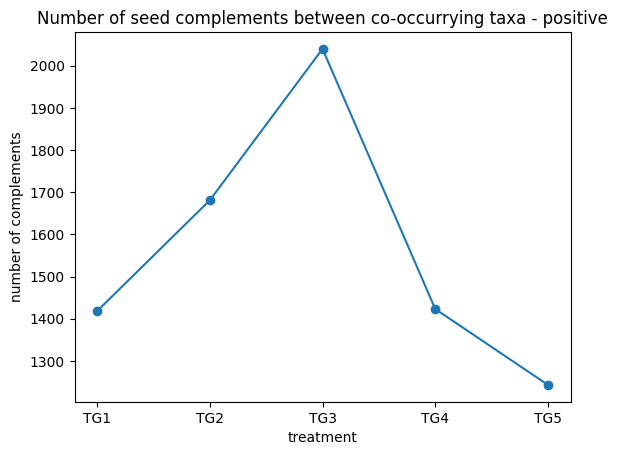

In [37]:
plt.plot(treatments, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")

# Show the plot
plt.show()

In [38]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(treatment_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(treatment_parsed_nets.values())
]

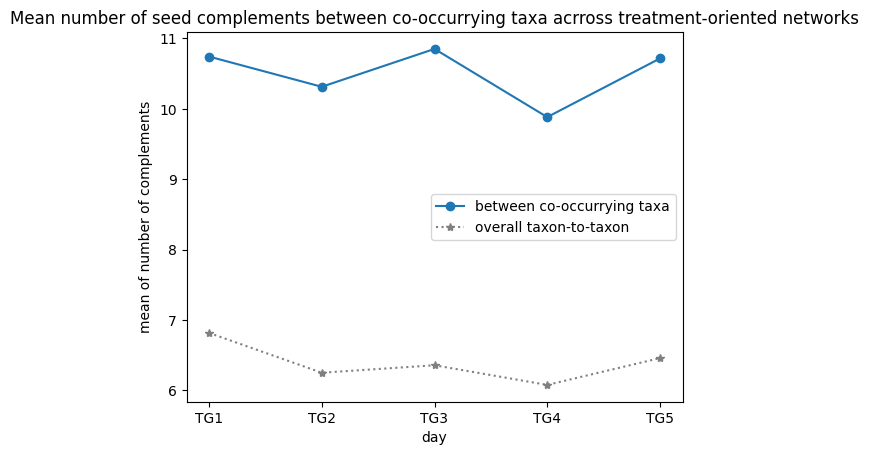

In [39]:
plt.plot(treatments, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(treatments, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")

# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross treatment-oriented networks")

plt.legend()

# Show the plot
plt.show()

#### Unique compounds involved in potential cross-feedings of co-occurrying taxa

In [40]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in treatment_parsed_nets.items()
]

lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

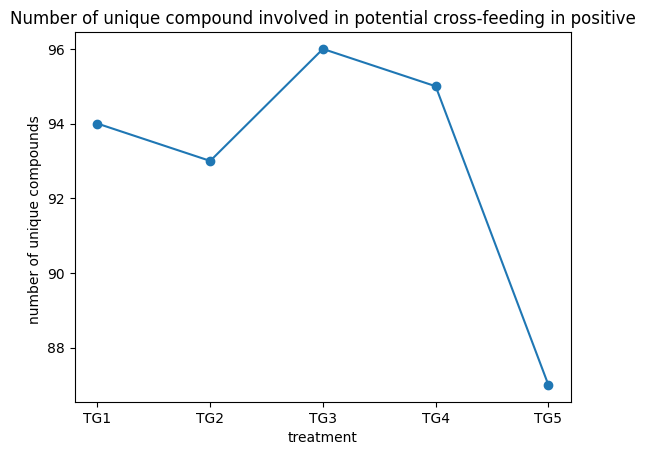

In [41]:
plt.plot(treatments, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [42]:
treatment_set = { i: j for i,j in zip(treatments, unique_compounds_in_cf_of_positive_associated_taxa)}

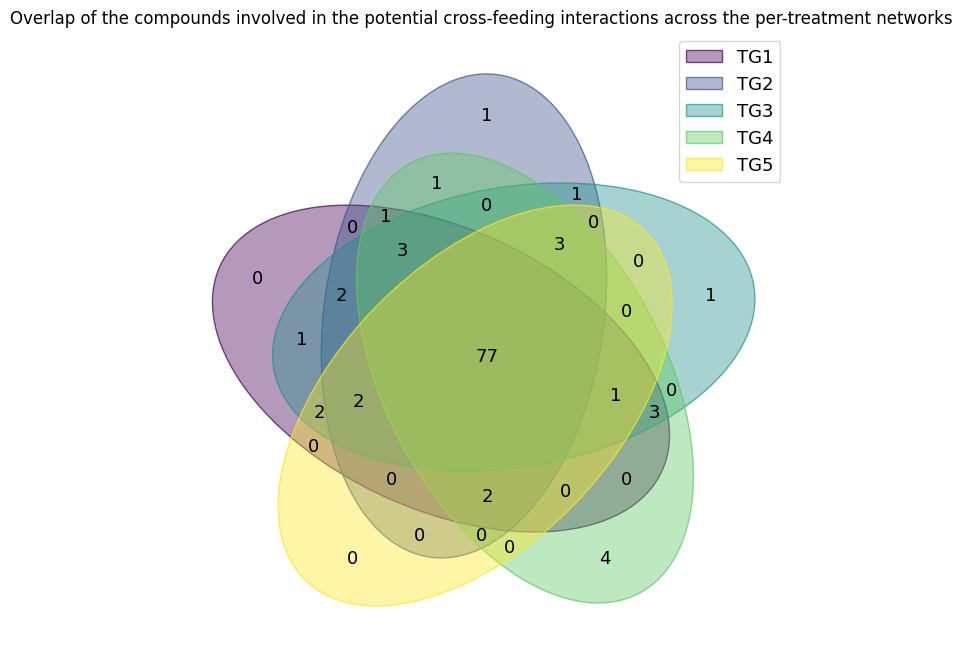

In [43]:
venn(treatment_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-treatment networks")

# Show the plot
plt.show()